In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from scipy.optimize import curve_fit
import datetime
from statsmodels.stats.multitest import multipletests
from cedne import utils
import cedne
import pywt
import copy
import tensorly
from tensorly.decomposition import parafac
from tensorly import partial_svd
from tensorly import transpose as tl_transpose
from tensorly.decomposition import tucker
from tensorly.tenalg import multi_mode_dot
from tensorly.tenalg import mode_dot
from tensorly import kruskal_to_tensor
from tensorly import tensor
from tensorly import unfold
from tensorly import fold
from tensorly import concatenate as tl_concatenate
from tensorly.tenalg import svd_interface
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
tensorly.set_backend('pytorch')
import torch
import plotly.graph_objs as go
from typing import List, Dict, Tuple, Any, Callable
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
matplotlib.__version__

'3.10.5'

In [3]:
today = str(datetime.datetime.now()).split(' ')[0]
outputDir = "Output/" + today + "/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

num_timepoints = 450
genotypes = ['N2', 'inx-7-mutant', 'inx-7-rescue']
conds = ['naive', 'trained']
stimuli = ['OP-PA-OP', 'OP-Buffer-OP', 'Buffer-PA-Buffer', 'Buffer-Buffer-Buffer', 'OP-gacA-OP']
promoters = ['ncs-1', 'inx-4', 'glr-1', 'acr-5', 'inx-4+mbr-1', 'flp-3p+flp-7p+nmr-1p+sro-1p', 'odr-2(2b)+odr-2(18)p']
promoter_names = {
    'glr-1': 'inter-motor group',
    'ncs-1': 'sensory-inter group I',
    'inx-4': 'sensory-inter group II',
    'inx-4+mbr-1': 'sensory-inter group III',
    'acr-5': 'sensory-inter-motor group I',
    'odr-2(2b)+odr-2(18)p': 'sensory-inter-motor group II',
    'flp-3p+flp-7p+nmr-1p+sro-1p': 'sensory-inter-motor group III'
    }

In [4]:
single_column = 90
double_column = 180
max_height = 170
font_size_big = 7 #pts
font_size_mid = 6
font_size_small = 5
DPI = 600

In [5]:
def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

In [6]:
picklefile = "../..//whole-brain-learning/Output/2025-12-24/worm_tensors.pickle"

with open(picklefile, 'rb') as f:
    all_neurs_set, worm_tensors_ori, worm_tensors = pickle.load(f)

In [7]:
def makeBinaryMask(tensor):
    # Create a binary mask based on the tensor values
    mask = np.ones(tensor.shape, dtype=bool)
    mask[np.isnan(tensor)] = 0
    return mask

In [8]:
color_stim = {'OP': '#e4ab24',
              'PA': '#1a9d77',
              'Buffer': '#f9f4d7'}
color_conds = {'naive': '#888666',
               'trained': '#6b3e98', 
               'gacA-trained': "#7a1652"}

## Getting common temporal factors across OP-PA and Buffer-PA.

In [9]:
def get_common_worm_counts(worm_tensors, conds=('naive', 'trained'), common_length=9, promoter_exceptions=None):
    """
    Computes the minimum number of worms per genotype × stimulus that are available across promoters.

    Args:
        worm_tensors (dict): Nested dictionary [genotype][promoter][stimulus][condition] → tensor
        conds (tuple): Conditions to consider (default: ('naive', 'trained'))
        common_length (int): Initial high value to start min() comparisons
        promoter_exceptions (list or set): Promoters to skip

    Returns:
        sampleNum (dict): [genotype][stimulus] → min worm count across conditions and promoters
    """
    if promoter_exceptions is None:
        promoter_exceptions = set()
    else:
        promoter_exceptions = set(promoter_exceptions)

    sampleNum = {}
    learningNum = {}

    for genotype in worm_tensors:
        sampleNum[genotype] = {}
        learningNum[genotype] = {}
        for promoter in worm_tensors[genotype]:
            learningNum[genotype][promoter] = {}
            if promoter in promoter_exceptions:
                continue
            for stimulus in worm_tensors[genotype][promoter]:
                # Initialize if not already present
                if stimulus not in learningNum[genotype][promoter]:
                    learningNum[genotype][promoter][stimulus] = {}
                if stimulus not in sampleNum[genotype]:
                    sampleNum[genotype][stimulus] = common_length

                # Check both conditions exist
                if all(cond in worm_tensors[genotype][promoter][stimulus] for cond in conds):
                    n_naive = worm_tensors[genotype][promoter][stimulus][conds[0]].shape[2]
                    n_trained = worm_tensors[genotype][promoter][stimulus][conds[1]].shape[2]
                    sampleNum[genotype][stimulus] = min(sampleNum[genotype][stimulus], n_naive, n_trained)

                    print(f"{genotype} {promoter} {stimulus} — Naive: {n_naive}, Trained: {n_trained}")
                    learningNum[genotype][promoter][stimulus]['naive'] = n_naive
                    learningNum[genotype][promoter][stimulus]['trained'] = n_trained

    return sampleNum, learningNum

def convert_worm_tensors_with_masks(worm_tensors, sampleNum, all_neurs_set, num_timepoints,
                                     conds=('naive', 'trained'), promoter_exceptions=None):
    """
    Converts worm_tensors into standardized tensors with masks for decomposition,
    subsampling worms and flattening for masking.

    Args:
        worm_tensors (dict): Nested dict [genotype][promoter][stimulus][cond] -> ndarray (neurons x time x worms)
        sampleNum (dict): [genotype][stimulus] -> common worm count
        all_neurs_set (dict): [genotype][promoter][stimulus] -> list of neuron indices to keep
        conds (tuple): Conditions to use (default: ('naive', 'trained'))
        promoter_exceptions (list or set): Promoters to skip

    Returns:
        worm_tensors_converted (dict): [genotype][promoter][stimulus] -> standardized tensor (neurons x time x worms)
        masks (dict): Same structure as above; binary mask tensors
    """
    if promoter_exceptions is None:
        promoter_exceptions = set()
    else:
        promoter_exceptions = set(promoter_exceptions)

    worm_tensors_converted = {}
    masks = {}

    for genotype in worm_tensors:
        worm_tensors_converted[genotype] = {}
        masks[genotype] = {}
        for promoter in worm_tensors[genotype]:
            if promoter in promoter_exceptions:
                continue
            worm_tensors_converted[genotype][promoter] = {}
            masks[genotype][promoter] = {}
            for stimulus in worm_tensors[genotype][promoter]:
                if (stimulus not in sampleNum.get(genotype, {})) or \
                   (stimulus not in all_neurs_set.get(genotype, {}).get(promoter, {})):
                    continue

                print(genotype, promoter, stimulus)
                print("Num worms:", sampleNum[genotype][stimulus],
                      "Num neurons:", len(all_neurs_set[genotype][promoter][stimulus]))

                num_neurons = len(all_neurs_set[genotype][promoter][stimulus])
                num_worms = sampleNum[genotype][stimulus]
                bigmat = np.empty((num_neurons, num_timepoints, num_worms * 2))
                j = 0

                for cond in conds:
                    worms_available = worm_tensors[genotype][promoter][stimulus][cond].shape[2]
                    selected_indices = np.random.choice(worms_available, num_worms, replace=False)
                    for i in selected_indices:
                        bigmat[:, :, j] = worm_tensors[genotype][promoter][stimulus][cond][:, :, i]
                        j += 1

                reshaped = bigmat.reshape((-1, bigmat.shape[-1]))  # neurons*time × worms

                # Mask
                binary_mask = makeBinaryMask(reshaped)
                masks[genotype][promoter][stimulus] = torch.tensor(binary_mask.reshape(bigmat.shape))

                # Standardize (optional — with_mean=False to preserve scale)
                # scaler = StandardScaler(with_mean=False)
                # scaler = StandardScaler(with_mean=True)
                # scaled = scaler.fit_transform(reshaped)
                scaled = reshaped 

                scaled_tensor = torch.tensor(scaled.reshape(bigmat.shape))
                worm_tensors_converted[genotype][promoter][stimulus] = scaled_tensor

    return worm_tensors_converted, masks

def convert_worm_tensors_with_masks_no_common_num(worm_tensors, all_neurs_set, num_timepoints,
                                     conds=('naive', 'trained'), promoter_exceptions=None):
    """
    Converts worm_tensors into standardized tensors with masks for decomposition,
    subsampling worms and flattening for masking.

    Args:
        worm_tensors (dict): Nested dict [genotype][promoter][stimulus][cond] -> ndarray (neurons x time x worms)
        all_neurs_set (dict): [genotype][promoter][stimulus] -> list of neuron indices to keep
        conds (tuple): Conditions to use (default: ('naive', 'trained'))
        promoter_exceptions (list or set): Promoters to skip

    Returns:
        worm_tensors_converted (dict): [genotype][promoter][stimulus] -> standardized tensor (neurons x time x worms)
        masks (dict): Same structure as above; binary mask tensors
    """
    if promoter_exceptions is None:
        promoter_exceptions = set()
    else:
        promoter_exceptions = set(promoter_exceptions)

    worm_tensors_converted = {}
    masks = {}

    for genotype in worm_tensors:
        worm_tensors_converted[genotype] = {}
        masks[genotype] = {}
        for promoter in worm_tensors[genotype]:
            if promoter in promoter_exceptions:
                continue
            worm_tensors_converted[genotype][promoter] = {}
            masks[genotype][promoter] = {}
            for stimulus in worm_tensors[genotype][promoter]:

                print(genotype, promoter, stimulus)
                num_neurons = len(all_neurs_set[genotype][promoter][stimulus])
                num_worms = worm_tensors[genotype][promoter][stimulus]['naive'].shape[2] + worm_tensors[genotype][promoter][stimulus]['trained'].shape[2]
                bigmat = np.empty((num_neurons, num_timepoints, num_worms))
                j = 0

                for cond in conds:
                    worms_available = worm_tensors[genotype][promoter][stimulus][cond].shape[2]
                    for i in range(worms_available):
                        bigmat[:, :, j] = worm_tensors[genotype][promoter][stimulus][cond][:, :, i]
                        j += 1

                reshaped = bigmat.reshape((-1, bigmat.shape[-1]))  # neurons*time × worms

                # Mask
                binary_mask = makeBinaryMask(reshaped)
                masks[genotype][promoter][stimulus] = torch.tensor(binary_mask.reshape(bigmat.shape))

                scaled = reshaped 

                scaled_tensor = torch.tensor(scaled.reshape(bigmat.shape))
                worm_tensors_converted[genotype][promoter][stimulus] = scaled_tensor

    return worm_tensors_converted, masks

def pick_only_stim_periods(worm_tensors, stim_period=(0,450)):
    worm_tensors_clean= {}
    for genotype in worm_tensors:
        worm_tensors_clean[genotype] = {}
        for promoter in worm_tensors[genotype]:
            worm_tensors_clean[genotype][promoter] = {}
            for stimulus in worm_tensors[genotype][promoter]:
                worm_tensors_clean[genotype][promoter][stimulus] = {} 
                for cond in worm_tensors[genotype][promoter][stimulus]: 
                    worm_tensors_clean[genotype][promoter][stimulus][cond] =  worm_tensors[genotype][promoter][stimulus][cond][:,stim_period[0]:stim_period[1], :]
    return worm_tensors_clean

In [10]:
promoter_exceptions = [] #['flp-3p+flp-7p+nmr-1p+sro-1p']
common_length = 9
stim_period=(150,450)
num_timepoints = stim_period[1]-stim_period[0]
worm_tensors_stimonly = pick_only_stim_periods(worm_tensors, stim_period = stim_period) 
sampleNum, learnNum = get_common_worm_counts(worm_tensors_stimonly, common_length=common_length, promoter_exceptions=promoter_exceptions)
#                                                               conds=('naive', 'trained'), promoter_exceptions=promoter_exceptions)
worm_tensors_converted, _ = convert_worm_tensors_with_masks_no_common_num(worm_tensors_stimonly, all_neurs_set, num_timepoints,
                                                                   conds=('naive', 'trained'), promoter_exceptions=promoter_exceptions)

worm_tensors_ori_stimonly = pick_only_stim_periods(worm_tensors_ori, stim_period = stim_period) 
_, masks = convert_worm_tensors_with_masks_no_common_num(worm_tensors_ori_stimonly, all_neurs_set, num_timepoints,
                                                                   conds=('naive', 'trained'), promoter_exceptions=promoter_exceptions)

N2 ncs-1 OP-PA-OP — Naive: 19, Trained: 20
N2 ncs-1 OP-Buffer-OP — Naive: 14, Trained: 17
N2 ncs-1 Buffer-PA-Buffer — Naive: 20, Trained: 21
N2 ncs-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 ncs-1 OP-gacA-OP — Naive: 14, Trained: 16
N2 inx-4 OP-PA-OP — Naive: 22, Trained: 23
N2 inx-4 Buffer-PA-Buffer — Naive: 21, Trained: 21
N2 glr-1 OP-PA-OP — Naive: 25, Trained: 22
N2 glr-1 Buffer-PA-Buffer — Naive: 19, Trained: 26
N2 glr-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 acr-5 OP-PA-OP — Naive: 20, Trained: 22
N2 acr-5 Buffer-PA-Buffer — Naive: 15, Trained: 17
N2 acr-5 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 inx-4+mbr-1 OP-PA-OP — Naive: 25, Trained: 24
N2 inx-4+mbr-1 Buffer-PA-Buffer — Naive: 15, Trained: 19
N2 inx-4+mbr-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 9
N2 flp-3p+flp-7p+nmr-1p+sro-1p OP-PA-OP — Naive: 22, Trained: 19
N2 flp-3p+flp-7p+nmr-1p+sro-1p Buffer-PA-Buffer — Naive: 22, Trained: 17
N2 odr-2(2b)+odr-2(18)p OP-PA-OP — Naive: 22, Trained: 21
N2 od

In [11]:
common_length = 20
R_t = 6
stimulus_filter = [
    'OP-PA-OP',
 'Buffer-PA-Buffer'
]
genotype_filter = ['N2']
common_over_promoters_tensor = {}
unfolded_masks = {}
common_all = []
masks_all = []
for genotype in worm_tensors:
# for genotype in worm_tensors_converted:
    if genotype in genotype_filter: #
        common_over_promoters_tensor[genotype] = {}
        unfolded_masks[genotype] = {}
        for promoter in worm_tensors_converted[genotype]:
            for stimulus in worm_tensors_converted[genotype][promoter]:
                if stimulus in stimulus_filter:
                    if not stimulus in common_over_promoters_tensor[genotype].keys():
                        common_over_promoters_tensor[genotype][stimulus] = []
                        unfolded_masks[genotype][stimulus] = []
                    common_over_promoters_tensor[genotype][stimulus].append(unfold(worm_tensors_converted[genotype][promoter][stimulus], mode=1))
                    unfolded_masks[genotype][stimulus].append(unfold(masks[genotype][promoter][stimulus], mode=1))
                    common_all.append(unfold(worm_tensors_converted[genotype][promoter][stimulus], mode=1))
                    masks_all.append(unfold(masks[genotype][promoter][stimulus], mode=1))

common_all_pre = tl_concatenate(common_all, axis=1)
masks_all = tl_concatenate(masks_all, axis=1)


scaler = StandardScaler(with_mean=False)
# scaler = StandardScaler(with_mean=True)
common_all = torch.tensor(scaler.fit_transform(common_all_pre))

if masks_all.dtype == torch.bool:
    masks_all = masks_all.float()

svd = svd_interface(
            common_all,
            n_eigenvecs=R_t,
            random_state=cedne.RANDOM_SEED,
            return_eigenvectors=True,
            mask = masks_all,
            n_iter_mask_imputation=3
        )

common_temporal_basis = {}
for genotype in worm_tensors_converted:
    common_temporal_basis[genotype] = {}
    for stimulus in stimuli: #Since this is common over genotypes and stimuli
        common_temporal_basis[genotype][stimulus] = svd[0] 
# common_temporal_basis = svd[0]
common_singular_values = svd[1]  # shape (R_t,)

# Variance explained calculation
singular_values_squared = common_singular_values ** 2

total_data_variance = torch.sum(common_all ** 2)

total_variance = torch.sum(singular_values_squared)
variance_explained = singular_values_squared / total_data_variance  # shape (R_t,)
print("Variance explained per temporal component:")
print(variance_explained)
print("Cumulative variance explained:")
print(torch.cumsum(variance_explained, dim=0))
print("Shape of common tensor:", common_all.shape)

Variance explained per temporal component:
tensor([0.7498, 0.1114, 0.0400, 0.0228, 0.0125, 0.0097], dtype=torch.float64)
Cumulative variance explained:
tensor([0.7498, 0.8612, 0.9011, 0.9240, 0.9365, 0.9461], dtype=torch.float64)
Shape of common tensor: torch.Size([300, 7234])


## Common neural components

In [12]:
## Common neural components
stimulus_filter = [
    'OP-PA-OP',
 'Buffer-PA-Buffer'
]
genotype_filter = ['N2']
R_n = 5
by_promoters_tensor = {}
common_neural_basis = {}
common_neurons = {}
common_neurons_indices = {}

for promoter in worm_tensors_converted['N2']:
    # choose one stimulus as the reference order
    ref_stim = stimulus_filter[0]
    ref_list = all_neurs_set['N2'][promoter][ref_stim]

    # keep only names that appear in ALL selected stimuli, preserving ref_list order
    common_list = [n for n in ref_list
                if all(n in all_neurs_set['N2'][promoter][s] for s in stimulus_filter)]

    # indices per stimulus in that SAME order
    common_idx = {
        s: [all_neurs_set['N2'][promoter][s].index(n) for n in common_list]
        for s in stimulus_filter
    }

    # use common_list and common_idx everywhere below
    common_neurons[promoter] = common_list                # <- list, ordered
    common_neurons_indices[promoter] = common_idx

for genotype in worm_tensors_converted:
    if genotype in genotype_filter: #
        by_promoters_tensor[genotype] = {}
        for promoter in worm_tensors_converted[genotype]:
            if not promoter in by_promoters_tensor[genotype]:
                by_promoters_tensor[genotype][promoter] = {}
            masks_all_neurons = []
            common_all = []
            for stimulus in worm_tensors_converted[genotype][promoter]:
                if stimulus in stimulus_filter:
                    by_promoters_tensor[genotype][promoter][stimulus] = worm_tensors_converted[genotype][promoter][stimulus][common_neurons_indices[promoter][stimulus],:,:]
                    # common_neurons_neural_components[genotype][promoter][stimulus] = np.array(common_neurons[promoter])[common_neurons_indices[promoter][stimulus]]
                    # unfolded_masks[genotype][stimulus].append(unfold(masks[genotype][promoter][stimulus], mode=1))
                    common_all.append(unfold(worm_tensors_converted[genotype][promoter][stimulus][common_neurons_indices[promoter][stimulus],:,:], mode=0))
                    masks_all_neurons.append(unfold(masks[genotype][promoter][stimulus][common_neurons_indices[promoter][stimulus],:,:], mode=0))

            common_all_neurons_pre = tl_concatenate(common_all, axis=-1)
            masks_all_neurons = tl_concatenate(masks_all_neurons, axis=-1)
            
            scaler = StandardScaler(with_mean=False)
            # scaler = StandardScaler(with_mean=True)
            common_all_neurons = torch.tensor(scaler.fit_transform(common_all_neurons_pre))

            if masks_all_neurons.dtype == torch.bool:
                masks_all_neurons = masks_all_neurons.float()

            svd = svd_interface(
                        common_all_neurons,
                        n_eigenvecs=R_n,
                        random_state=cedne.RANDOM_SEED,
                        return_eigenvectors=True,
                        mask = masks_all_neurons,
                        n_iter_mask_imputation=3
                    )
            common_neural_basis[promoter] = svd[0] 
            # common_temporal_basis = svd[0]
            common_singular_values = svd[1]  # shape (R_t,)

            # Variance explained calculation
            singular_values_squared = common_singular_values ** 2

            total_data_variance = torch.sum(common_all_neurons ** 2)

            total_variance = torch.sum(singular_values_squared)
            variance_explained = singular_values_squared / total_data_variance  # shape (R_t,)
            print(f"Variance explained per neural component for {genotype} {promoter}:")
            print(variance_explained)
            print("Cumulative variance explained:")
            print(torch.cumsum(variance_explained, dim=0))
            print("Shape of common tensor:", common_all_neurons.shape)

Variance explained per neural component for N2 ncs-1:
tensor([0.3891, 0.1507, 0.0901, 0.0694, 0.0654], dtype=torch.float64)
Cumulative variance explained:
tensor([0.3891, 0.5398, 0.6299, 0.6993, 0.7646], dtype=torch.float64)
Shape of common tensor: torch.Size([15, 24000])
Variance explained per neural component for N2 inx-4:
tensor([0.5877, 0.1344, 0.1137, 0.0637, 0.0590], dtype=torch.float64)
Cumulative variance explained:
tensor([0.5877, 0.7221, 0.8357, 0.8995, 0.9585], dtype=torch.float64)
Shape of common tensor: torch.Size([6, 26100])
Variance explained per neural component for N2 glr-1:
tensor([0.4471, 0.1372, 0.1224, 0.0798, 0.0536], dtype=torch.float64)
Cumulative variance explained:
tensor([0.4471, 0.5843, 0.7068, 0.7866, 0.8403], dtype=torch.float64)
Shape of common tensor: torch.Size([10, 27600])
Variance explained per neural component for N2 acr-5:
tensor([0.3532, 0.1459, 0.1115, 0.0755, 0.0629], dtype=torch.float64)
Cumulative variance explained:
tensor([0.3532, 0.4990, 0.6

## Extended Fig. 10a, Supplementary Fig. 9

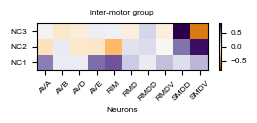

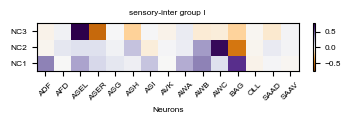

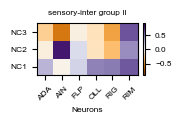

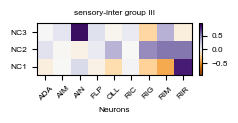

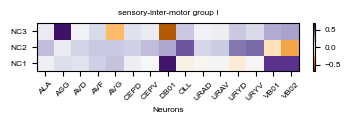

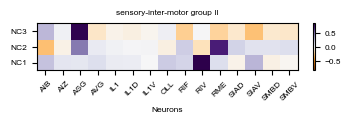

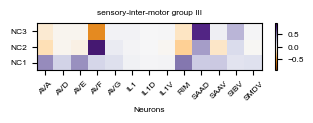

In [13]:
for prom in promoter_names:
    vm = common_neural_basis[prom].abs().max()
    ind = np.argsort(common_neurons[prom])
    f, ax = plt.subplots(figsize = mm_to_inches(((0.2 + common_neural_basis[prom].shape[0]/15)*single_column/1.25, max_height/6)), layout='constrained')
    cb = ax.pcolor(common_neural_basis[prom][ind, :3].T, cmap='PuOr', vmin=-vm, vmax=vm)
    ax.set_xticks(np.arange(common_neural_basis[prom].shape[0])+0.5, np.array(common_neurons[prom])[ind], fontsize=font_size_mid, rotation=45)
    ax.set_yticks(np.arange(common_neural_basis[prom].shape[1])[:3]+0.5, [f"NC{str(i)}" for i in range(1, 4)], fontsize=font_size_mid)
    cbar = plt.colorbar(cb)
    cbar.ax.tick_params(labelsize=font_size_mid)
    ax.set_xlabel('Neurons', fontsize=font_size_mid)
    plt.title(promoter_names[prom], fontsize=font_size_mid)
    # ax.set_ylabel('Neural\n component', fontsize=font_size_mid)
    # plt.savefig(f"figures/common_neural_components_{prom}.svg", transparent=True)
    plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def variance_in_common_basis(X_naive, X_trained, U):
    # U: (N, Rn) orthonormal; X_*: (N, T, W)
    def energy_per_comp(X):
        Y = np.tensordot(U.T, X, axes=(1,0))   # (Rn, T, W)
        return np.sum(Y**2, axis=(1,2))        # (Rn,)
    
    total_energy_naive = (X_naive**2).sum()
    total_energy_trained = (X_trained**2).sum()

    Ena = energy_per_comp(X_naive)
    Etr = energy_per_comp(X_trained)

    total = (Ena + Etr).sum()
    share_comb_na = Ena / total
    share_comb_tr = Etr / total

    dist_na = Ena / Ena.sum()
    dist_tr = Etr / Etr.sum()

    frac_explained_na = Ena / total_energy_naive
    frac_explained_tr = Etr / total_energy_trained

    return dict(
        E_na=Ena, E_tr=Etr,
        share_comb_na=share_comb_na, share_comb_tr=share_comb_tr,
        dist_na=dist_na, dist_tr=dist_tr,
        frac_explained_na=frac_explained_na, frac_explained_tr=frac_explained_tr
    )

def plot_var_explained(var_naive, var_trained, label="", save=False):
    figsize = mm_to_inches((double_column/7, double_column/7))
    fig, ax = plt.subplots(figsize=figsize, layout='constrained')
    ax.plot(np.arange(1,len(var_naive)+1), np.cumsum(var_naive), label="naive", color=color_conds['naive'])
    ax.plot(np.arange(1,len(var_trained)+1), np.cumsum(var_trained), label="trained", color=color_conds['trained'])
    ax.set_xlabel("Neural component", fontsize=font_size_mid)
    # ax.set_ylabel("Variance explained", fontsize=font_size_mid)
    ax.set_xticks(np.arange(1,len(var_naive)+1), [str(i) for i in range(1, len(var_naive)+1)], fontsize=font_size_mid)
    ax.set_yticks([0,0.5,1], [0,0.5,1], fontsize=font_size_mid)
    # ax.set_ylim((0,1))
    # ax.legend(frameon=False)
    utils.simpleaxis(ax)
    ax.set_title(f"{label}", fontsize=font_size_mid)
    if not save == False:
        plt.savefig(save, transparent=True)
    plt.show()
    return var_naive, var_trained

In [15]:
common_neurons_indices['ncs-1']

{'OP-PA-OP': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'Buffer-PA-Buffer': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]}

OP-PA-OP
N2 ncs-1 OP-PA-OP
torch.Size([15, 300, 9]) torch.Size([15, 300, 30])


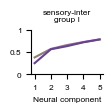

Buffer-PA-Buffer
N2 ncs-1 Buffer-PA-Buffer
torch.Size([15, 300, 9]) torch.Size([15, 300, 32])


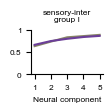

OP-PA-OP
N2 inx-4 OP-PA-OP
torch.Size([6, 300, 9]) torch.Size([6, 300, 36])


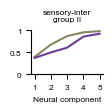

Buffer-PA-Buffer
N2 inx-4 Buffer-PA-Buffer
torch.Size([6, 300, 9]) torch.Size([6, 300, 33])


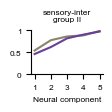

OP-PA-OP
N2 glr-1 OP-PA-OP
torch.Size([10, 300, 9]) torch.Size([10, 300, 38])


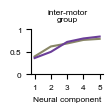

Buffer-PA-Buffer
N2 glr-1 Buffer-PA-Buffer
torch.Size([10, 300, 9]) torch.Size([10, 300, 36])


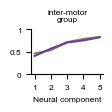

OP-PA-OP
N2 acr-5 OP-PA-OP
torch.Size([15, 300, 9]) torch.Size([15, 300, 33])


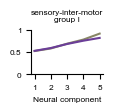

Buffer-PA-Buffer
N2 acr-5 Buffer-PA-Buffer
torch.Size([15, 300, 9]) torch.Size([15, 300, 23])


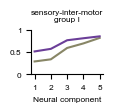

OP-PA-OP
N2 inx-4+mbr-1 OP-PA-OP
torch.Size([9, 300, 9]) torch.Size([9, 300, 40])


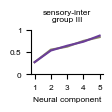

Buffer-PA-Buffer
N2 inx-4+mbr-1 Buffer-PA-Buffer
torch.Size([9, 300, 9]) torch.Size([9, 300, 25])


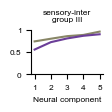

OP-PA-OP
N2 flp-3p+flp-7p+nmr-1p+sro-1p OP-PA-OP
torch.Size([13, 300, 9]) torch.Size([13, 300, 32])


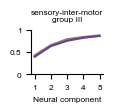

Buffer-PA-Buffer
N2 flp-3p+flp-7p+nmr-1p+sro-1p Buffer-PA-Buffer
torch.Size([13, 300, 9]) torch.Size([13, 300, 30])


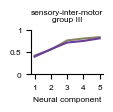

OP-PA-OP
N2 odr-2(2b)+odr-2(18)p OP-PA-OP
torch.Size([15, 300, 9]) torch.Size([15, 300, 34])


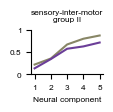

Buffer-PA-Buffer
N2 odr-2(2b)+odr-2(18)p Buffer-PA-Buffer
torch.Size([15, 300, 9]) torch.Size([15, 300, 38])


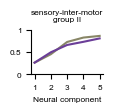

OP-PA-OP
inx-7-mutant ncs-1 OP-PA-OP
torch.Size([15, 300, 9]) torch.Size([15, 300, 23])


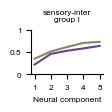

OP-PA-OP
inx-7-rescue ncs-1 OP-PA-OP
torch.Size([15, 300, 9]) torch.Size([15, 300, 24])


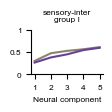

In [16]:
ref_stimulus = {"OP-Buffer-OP": "OP-PA-OP", "OP-gacA-OP": "OP-PA-OP", "Buffer-PA-Buffer": "Buffer-PA-Buffer", "OP-PA-OP": "OP-PA-OP"}
for genotype in worm_tensors_converted:
    for promoter in worm_tensors_converted[genotype]:
        # for stimulus in worm_tensors_converted[genotype][promoter]:
        for stimulus in ['OP-PA-OP', 'Buffer-PA-Buffer']:
            if stimulus in worm_tensors_converted[genotype][promoter]:
                print(stimulus)
                X_naive = worm_tensors_converted[genotype][promoter][stimulus][common_neurons_indices[promoter][stimulus],:, :sampleNum[genotype][stimulus]]
                X_trained = worm_tensors_converted[genotype][promoter][stimulus][common_neurons_indices[promoter][stimulus],:,sampleNum[genotype][stimulus]:]
                print(genotype, promoter, stimulus )
                print(X_naive.shape, X_trained.shape)
                var_exp_dict = variance_in_common_basis(X_naive, X_trained, U=common_neural_basis[promoter])
                plot_label = '\ng'.join(promoter_names[promoter].split(' g'))
                plot_var_explained(var_exp_dict['frac_explained_na'], var_exp_dict['frac_explained_tr'], label=f"{plot_label}")#, save=f"{'figures/'}{genotype}_{promoter}_{stimulus}_neural_components_var_explained.svg")

In [17]:
plt.close('all')

## Extended Fig. 10b

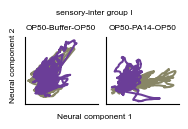

In [18]:
strain = 'N2'
prom = 'ncs-1'
ctx_op = 'OP-PA-OP'
ctx_buf = 'OP-Buffer-OP'

neurs_op  = all_neurs_set[strain][prom][ctx_op]
neurs_buf = all_neurs_set[strain][prom][ctx_buf]
S = [n for n in neurs_op if n in neurs_buf]  # intersection in OP–PA order

# index maps
idx_op  = {n:i for i,n in enumerate(neurs_op)}
idx_buf = {n:i for i,n in enumerate(neurs_buf)}
S_idx_op  = torch.tensor([idx_op[n]  for n in S], dtype=torch.long)
S_idx_buf = torch.tensor([idx_buf[n] for n in S], dtype=torch.long)

proj_OP_Buffer = {ctx_op: [], ctx_buf: []}
learnNum_OP_Buffer = {ctx_op: {}, ctx_buf: {}}
figsize = mm_to_inches((single_column/2, single_column/3))
f, ax = plt.subplots(figsize=figsize, ncols=2, sharex=True, sharey=True, layout='constrained')
# ---- data ----
for cond in ['naive', 'trained']:
    X_op  = torch.as_tensor(worm_tensors[strain][prom][ctx_op][cond],  dtype=torch.float32)
    X_buf = torch.as_tensor(worm_tensors[strain][prom][ctx_buf][cond], dtype=torch.float32)

    # subset to S with consistent ordering
    X_op_S  = X_op.index_select(0, S_idx_op)     # (|S|, T, W)
    X_buf_S = X_buf.index_select(0, S_idx_buf)   # (|S|, T, W)

    # ---- OP–PA neuron basis ----
    W_full = torch.as_tensor(common_neural_basis[prom], dtype=torch.float32)  # (N_pa, r)
    r = W_full.shape[1]
    W_S = W_full.index_select(0, S_idx_op)  # (|S|, r)
    X_buf_S_c = X_buf_S
    # Stack time and worms into one axis for linear solve
    Nb, T, W = X_buf_S_c.shape
    X_mat = X_buf_S_c.reshape(Nb, T*W)           

    
    lam = 1e-6
    A_mat = W_S.T @ W_S + lam * torch.eye(r)
    C = torch.linalg.solve(A_mat, W_S.T @ X_mat)         # (r, TW)
    
    # Project OP context also
    
    X_op_S_c = X_op_S
    Nb_op, T, W_op = X_op_S_c.shape
    X_op_mat = X_op_S_c.reshape(Nb_op, T*W_op)            # (|S|, TW_op)
    C_op = torch.linalg.solve(A_mat, W_S.T @ X_op_mat)

    C_scores = C.reshape(r, T, W)
    C_op_scores = C_op.reshape(r, T, W_op)

    proj_OP_Buffer[ctx_buf].append(C_scores)
    learnNum_OP_Buffer[ctx_buf][cond] = C_scores.shape[2]
    proj_OP_Buffer[ctx_op].append(C_op_scores)
    learnNum_OP_Buffer[ctx_op][cond] = C_op_scores.shape[2]

    for j in range(W):
        ax[0].plot(C_scores[0, 150:, j], C_scores[1, 150:, j], label=f'OP-Buffer {cond}', color=color_conds[cond])
    for j in range(W_op):
        ax[1].plot(C_op_scores[0, 150:, j], C_op_scores[1, 150:, j],label=f'OP-PA {cond}', color=color_conds[cond] )

proj_OP_Buffer[ctx_buf] = torch.cat(proj_OP_Buffer[ctx_buf], dim=2)  # (r, T, total_W)
proj_OP_Buffer[ctx_op]  = torch.cat(proj_OP_Buffer[ctx_op], dim=2)    # (r, T, total_W)

f.supxlabel('Neural component 1', fontsize=font_size_mid)
f.supylabel('Neural component 2', fontsize=font_size_mid)
utils.simpleaxis(ax)
ax[0].set_title('OP50-Buffer-OP50', fontsize=font_size_mid)
ax[1].set_title('OP50-PA14-OP50', fontsize=font_size_mid)
ax[0].set_xticks([])
ax[0].set_yticks([])
f.suptitle(f'{promoter_names[promoter]}', fontsize=font_size_mid)
# plt.savefig(f"figures/{strain}_{prom}_OPBuffer_vs_OPPA_neural_components.svg", bbox_inches='tight', transparent=True)
plt.show()

## Extended Fig. 10c

torch.Size([5, 450, 14]) torch.Size([5, 450, 19])
torch.Size([5, 450, 16]) torch.Size([5, 450, 20])


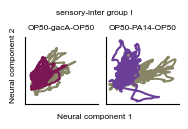

In [19]:
strain = 'N2'
prom = 'ncs-1'
ctx_op = 'OP-PA-OP'
ctx_gacA = 'OP-gacA-OP'

# ---- neuron sets and intersection (preserve OP–PA order) ----
neurs_op  = all_neurs_set[strain][prom][ctx_op]
neurs_gacA = all_neurs_set[strain][prom][ctx_gacA]
S = [n for n in neurs_op if n in neurs_gacA]  # intersection in OP–PA order

# index maps
idx_op  = {n:i for i,n in enumerate(neurs_op)}
idx_gacA = {n:i for i,n in enumerate(neurs_gacA)}
S_idx_op  = torch.tensor([idx_op[n]  for n in S], dtype=torch.long)
S_idx_gacA = torch.tensor([idx_gacA[n] for n in S], dtype=torch.long)

figsize = mm_to_inches((single_column/2, single_column/3))
f, ax = plt.subplots(figsize=figsize, ncols=2, sharex=True, sharey=True, layout='constrained')
gacA_proj = {ctx_op: [], ctx_gacA: []}
learnNum_gacA = {ctx_gacA: {}, ctx_op: {}}
for cond in ['naive', 'trained']:
    X_op  = torch.as_tensor(worm_tensors[strain][prom][ctx_op][cond],  dtype=torch.float32)
    X_gacA = torch.as_tensor(worm_tensors[strain][prom][ctx_gacA][cond], dtype=torch.float32)

    X_op_S  = X_op.index_select(0, S_idx_op)     
    X_gacA_S = X_gacA.index_select(0, S_idx_gacA)  

    W_full = torch.as_tensor(common_neural_basis[prom], dtype=torch.float32)  # (N_pa, r)
    r = W_full.shape[1]
    W_S = W_full.index_select(0, S_idx_op) 

    X_gacA_S_c = X_gacA_S
    Nb, T, W = X_gacA_S_c.shape
    X_mat = X_gacA_S_c.reshape(Nb, T*W)            

    lam = 1e-6
    A_mat = W_S.T @ W_S + lam * torch.eye(r)
    C = torch.linalg.solve(A_mat, W_S.T @ X_mat)        
    
    X_op_S_c = X_op_S #/ sd_op_S
    Nb_op, T, W_op = X_op_S_c.shape
    X_op_mat = X_op_S_c.reshape(Nb_op, T*W_op)          
    C_op = torch.linalg.solve(A_mat, W_S.T @ X_op_mat)

    C_scores = C.reshape(r, T, W)
    C_op_scores = C_op.reshape(r, T, W_op)
    print(C_scores.shape, C_op_scores.shape)

    gacA_proj[ctx_gacA].append(C_scores)
    gacA_proj[ctx_op].append(C_op_scores)
    
    learnNum_gacA[ctx_gacA][cond] = C_scores.shape[2]
    learnNum_gacA[ctx_op][cond] = C_op_scores.shape[2]
    for j in range(W):
        if cond == 'trained':
            color = color_conds['gacA-trained']
        else:
            color = color_conds['naive']
        ax[0].plot(C_scores[0, 150:, j], C_scores[1, 150:, j], label=f'OP-gacA {cond}', color=color)
    for j in range(W_op):
        ax[1].plot(C_op_scores[0, 150:, j], C_op_scores[1, 150:, j],label=f'OP-PA {cond}', color=color_conds[cond] )

gacA_proj[ctx_gacA] = torch.cat(gacA_proj[ctx_gacA], dim=2)  
gacA_proj[ctx_op] = torch.cat(gacA_proj[ctx_op], dim=2)

f.supxlabel('Neural component 1', fontsize=font_size_mid)
f.supylabel('Neural component 2', fontsize=font_size_mid)
utils.simpleaxis(ax)
ax[0].set_title('OP50-gacA-OP50', fontsize=font_size_mid)
ax[1].set_title('OP50-PA14-OP50', fontsize=font_size_mid)
ax[0].set_xticks([])
ax[0].set_yticks([])
f.suptitle(f'{promoter_names[promoter]}', fontsize=font_size_mid)
# plt.savefig(f"figures/{strain}_{prom}_OPgacA_vs_OPPA_neural_components.svg", bbox_inches='tight', transparent=True)
plt.show()

## Fig. 5b

Number of neurons in N2: 15
Number of neurons in inx-7-mutant: 15
Number of neurons in inx-7-rescue: 17
['ADF', 'AFD', 'ASEL', 'ASER', 'ASG', 'ASH', 'ASI', 'AVK', 'AWA', 'AWB', 'AWC', 'BAG', 'OLL', 'SAAD', 'SAAV']
torch.Size([15, 450, 19]) torch.Size([15, 450, 17]) torch.Size([15, 450, 18])
torch.Size([15, 450, 20]) torch.Size([15, 450, 15]) torch.Size([15, 450, 15])
torch.Size([5, 450, 39])
torch.Size([5, 450, 32])
torch.Size([5, 450, 33])


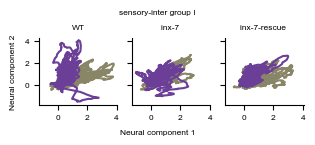

In [20]:
strain1 = 'N2'
strain2 = 'inx-7-mutant'
strain3 = 'inx-7-rescue'
prom = 'ncs-1'
ctx_op = 'OP-PA-OP'

neurs_st1 = all_neurs_set[strain1][prom][ctx_op]
neurs_st2 = all_neurs_set[strain2][prom][ctx_op]
neurs_st3 = all_neurs_set[strain3][prom][ctx_op]

print(f'Number of neurons in {strain1}: {len(neurs_st1)}')
print(f'Number of neurons in {strain2}: {len(neurs_st2)}')
print(f'Number of neurons in {strain3}: {len(neurs_st3)}')
S = [n for n in neurs_st1 if n in neurs_st2 and n in neurs_st3]  # intersection in OP–PA order
print(S)

# index maps
idx_st1  = {n:i for i,n in enumerate(neurs_st1)}
idx_st2 = {n:i for i,n in enumerate(neurs_st2)}
idx_st3 = {n:i for i,n in enumerate(neurs_st3)}
S_idx_st1  = torch.tensor([idx_st1[n]  for n in S], dtype=torch.long)
S_idx_st2 = torch.tensor([idx_st2[n] for n in S], dtype=torch.long)
S_idx_st3 = torch.tensor([idx_st3[n] for n in S], dtype=torch.long)

inx_7_projection = {s: {prom: {ctx_op: []} for prom in [prom]} for s in [strain1, strain2, strain3]}
learnNum_inx7 = {s: {prom: {ctx_op: {cond: [] for cond in ['naive', 'trained']}} for prom in [prom]} for s in [strain1, strain2, strain3]}
figsize = mm_to_inches((double_column*3/7, max_height/5))
f, ax = plt.subplots(figsize=figsize, ncols=3, sharex=True, sharey=True, layout='constrained')
for cond in ['naive', 'trained']:
    X_st1  = torch.as_tensor(worm_tensors[strain1][prom][ctx_op][cond],  dtype=torch.float32)
    X_st2 = torch.as_tensor(worm_tensors[strain2][prom][ctx_op][cond], dtype=torch.float32)
    X_st3 = torch.as_tensor(worm_tensors[strain3][prom][ctx_op][cond], dtype=torch.float32)

    X_st1_S  = X_st1.index_select(0, S_idx_st1)     # (|S|, T, W)
    X_st2_S = X_st2.index_select(0, S_idx_st2)   # (|S|, T, W)
    X_st3_S = X_st3.index_select(0, S_idx_st3)   # (|S|, T, W)

    print(X_st1_S.shape, X_st2_S.shape, X_st3_S.shape)
    W_full = torch.as_tensor(common_neural_basis[prom], dtype=torch.float32)  # (N_pa, r)
    r = W_full.shape[1]
    N_S1 = W_full.index_select(0, S_idx_st1)  # (|S|, r)

    # ---- reshape for projection ----
    Nb, T, W1 = X_st1_S.shape
    X_mat1 = X_st1_S.reshape(Nb, T*W1)            # (|S|, TW)

    # Stack time and worms into one axis for linear solve
    Nb, T, W2 = X_st2_S.shape
    X_mat2 = X_st2_S.reshape(Nb, T*W2)            # (|S|, TW)
    
    Nb, T, W3 = X_st3_S.shape
    X_mat3 = X_st3_S.reshape(Nb, T*W3)            # (

    lam = 1e-6
    A_mat = N_S1.T @ N_S1 + lam * torch.eye(
    r, device=N_S1.device, dtype=N_S1.dtype
)
    C_s1 = torch.linalg.solve(A_mat, N_S1.T @ X_mat1)         # (r, TW)
    C_s2 = torch.linalg.solve(A_mat, N_S1.T @ X_mat2)
    C_s3 = torch.linalg.solve(A_mat, N_S1.T @ X_mat3)


    # ---- also return scores per time × worm as a tensor (r, T, W) ----
    C_s1_scores = C_s1.reshape(r, T, W1)
    C_s2_scores = C_s2.reshape(r, T, W2)
    C_s3_scores = C_s3.reshape(r, T, W3)


    for j in range(W1):
        ax[0].plot(C_s1_scores[0, 150:, j], C_s1_scores[1, 150:, j], label=f'{strain1} {cond}', color=color_conds[cond])
    for j in range(W2):
        ax[1].plot(C_s2_scores[0, 150:, j], C_s2_scores[1, 150:, j],label=f'{strain2} {cond}', color=color_conds[cond] )
    for j in range(W3):
        ax[2].plot(C_s3_scores[0, 150:, j], C_s3_scores[1, 150:, j],label=f'{strain3} {cond}', color=color_conds[cond] )
    
    inx_7_projection[strain1][prom][ctx_op].append(C_s1_scores)
    inx_7_projection[strain2][prom][ctx_op].append(C_s2_scores)
    inx_7_projection[strain3][prom][ctx_op].append(C_s3_scores)
    learnNum_inx7[strain1][prom][ctx_op][cond] = C_s1_scores.shape[2]
    learnNum_inx7[strain2][prom][ctx_op][cond] = C_s2_scores.shape[2]
    learnNum_inx7[strain3][prom][ctx_op][cond] = C_s3_scores.shape[2]

for s in [strain1, strain2, strain3]:
    for promoter in [prom]:
        for stimulus in [ctx_op]:
            inx_7_projection[s][prom][ctx_op] = torch.cat(inx_7_projection[s][prom][ctx_op], dim=2)
            print(inx_7_projection[s][prom][ctx_op].shape)

f.supxlabel('Neural component 1', fontsize=font_size_mid)
f.supylabel('Neural component 2', fontsize=font_size_mid)
utils.simpleaxis(ax)
for a in ax:
    a.tick_params(axis='both', which='both', labelsize=font_size_mid)
ax[0].set_title(f'WT', fontsize=font_size_mid)
ax[1].set_title(f'inx-7 ', fontsize=font_size_mid)
ax[2].set_title(f'{strain3} ', fontsize=font_size_mid)
f.suptitle(f'{promoter_names[prom]}', fontsize=font_size_mid)
# plt.savefig(f"figures/inx-7_{prom}_vs_N2_OP-PA_neural_components.svg", bbox_inches='tight', transparent=True)
plt.show()
# plt.close()
# print(inx_7_projection)

In [21]:
plt.close()

In [22]:
import numpy as np

def _angle_deg_between_2d(u, v, eps=1e-12, axis_sym=True):
    u = np.asarray(u, float); v = np.asarray(v, float)
    nu = np.linalg.norm(u); nv = np.linalg.norm(v)
    if nu < eps or nv < eps:
        return np.nan
    c = np.clip(np.dot(u, v)/(nu*nv), -1.0, 1.0)
    ang = float(np.degrees(np.arccos(c)))
    if axis_sym and ang > 90.0:
        ang = 180.0 - ang
    return ang

def _cov2(P, ridge=1e-9):
    P = np.asarray(P, float)
    P = P[~np.isnan(P).any(axis=1)]
    if P.shape[0] < 3:
        return ridge*np.eye(2)
    P = P - P.mean(axis=0, keepdims=True)
    return (P.T @ P) / max(P.shape[0]-1, 1) + ridge*np.eye(2)

def _major_axis_vec_2d(C):
    w, v = np.linalg.eigh(C)
    i = int(np.argmax(w))
    a = v[:, i]
    n = np.linalg.norm(a)
    return a / n if n > 1e-12 else np.array([1.0, 0.0])

def _eccentricity_2d(C):
    w, _ = np.linalg.eigh(C)
    w = np.sort(w)[::-1]
    return float((w[0]-w[1]) / max(w[0]+w[1], 1e-12))

def global_covaxis_tilt(Xn_TWd, Xt_TWd, ridge=1e-9):
    """
    Global covariance-axis tilt:
      - pool all points in window (time×worms) for each condition
      - compute covariances Cn, Ct and their major axes
      - return angle between axes + eccentricities so you know reliability
    """
    Pn = Xn_TWd.reshape(-1,2)
    Pt = Xt_TWd.reshape(-1,2)
    Cn = _cov2(Pn, ridge=ridge)
    Ct = _cov2(Pt, ridge=ridge)
    v1n = _major_axis_vec_2d(Cn)
    v1t = _major_axis_vec_2d(Ct)
    ang = _angle_deg_between_2d(v1n, v1t, axis_sym=True)
    ecc_n = _eccentricity_2d(Cn)
    ecc_t = _eccentricity_2d(Ct)
    return ang, ecc_n, ecc_t, Cn, Ct

def summarize_global_effects(projected_DTW, n_naive, tstart=150):
    """
    projected_DTW: (D,T,W) naive worms first then trained; uses first 2 components.
    """
    X = np.asarray(projected_DTW)[:2]               # (2,T,W)
    X = np.transpose(X, (1,2,0))[tstart:,:,:]       # (T',W,2)
    Xn = X[:, :n_naive, :]
    Xt = X[:, n_naive:, :]

    ang_cov, ecc_n, ecc_t, _, _ = global_covaxis_tilt(Xn, Xt)

    out = dict(
        covaxis_tilt_deg=float(ang_cov) if np.isfinite(ang_cov) else np.nan,
        ecc_naive=float(ecc_n), ecc_trained=float(ecc_t)
    )
    return out

def perm_test_global_covtilt(projected_DTW, n_naive, tstart=150,
                             nperm=2000, seed=0):
    rng = np.random.default_rng(seed)

    X = np.asarray(projected_DTW)[:2]
    X = np.transpose(X, (1,2,0))[tstart:,:,:]   # (T,W,2)
    T, W, _ = X.shape

    Xn = X[:, :n_naive, :]
    Xt = X[:, n_naive:, :]

    obs, _, _, _, _ = global_covaxis_tilt(Xn, Xt)

    allX = X.copy()
    null = np.zeros(nperm)

    for i in range(nperm):
        idx = rng.permutation(W)
        Xp = allX[:, idx, :]
        Xn_p = Xp[:, :n_naive, :]
        Xt_p = Xp[:, n_naive:, :]
        ang, _, _, _, _ = global_covaxis_tilt(Xn_p, Xt_p)
        null[i] = ang

    p = (np.sum(null >= obs) + 1) / (nperm + 1)
    return obs, p, null

def _eigvals_sorted(C):
    w, _ = np.linalg.eigh(C)
    w = np.sort(w)[::-1]
    return w

def _to_Xn_Xt_TWd(proj_DTW, n_naive, tstart=150, d=2):
    X = np.asarray(proj_DTW)[:d]                  # (d,T,W)
    X = np.transpose(X, (1,2,0))[tstart:,:,:]     # (T',W,d)
    Xn = X[:, :n_naive, :2]
    Xt = X[:, n_naive:, :2]
    return Xn, Xt

def _global_area_from_cov(X_TWd, ridge=1e-9):
    P = X_TWd.reshape(-1, 2)
    P = P[~np.isnan(P).any(axis=1)]
    C = _cov2(P, ridge=ridge)
    detC = np.linalg.det(C)
    if detC <= 0 or not np.isfinite(detC):
        return np.nan
    return float(np.sqrt(detC))  # “area” proxy in 2D

def global_contraction_ratio(projected_DTW, n_naive, tstart=150, ridge=1e-9):
    X = np.asarray(projected_DTW)[:2]                 # (2,T,W)
    X = np.transpose(X, (1,2,0))[tstart:,:,:]         # (T,W,2)
    Xn = X[:, :n_naive, :]
    Xt = X[:, n_naive:, :]

    An = _global_area_from_cov(Xn, ridge=ridge)
    At = _global_area_from_cov(Xt, ridge=ridge)
    ratio = float(At / An) if np.isfinite(An) and np.isfinite(At) and An > 0 else np.nan
    return ratio, An, At

def _cov2_centered(P, ridge=1e-12):
    """
    P: (N,2) points (may contain NaNs). Returns 2x2 covariance (centered) with ridge stabilization.
    """
    P = np.asarray(P, float)
    P = P[~np.isnan(P).any(axis=1)]
    if P.shape[0] < 3:
        return ridge * np.eye(2)

    P = P - P.mean(axis=0, keepdims=True)
    C = (P.T @ P) / max(P.shape[0] - 1, 1)

    sign, _ = np.linalg.slogdet(C)
    if sign <= 0 or not np.isfinite(sign):
        C = C + ridge * np.eye(2)
    return C

def _area_proxy_from_cov(C):
    """
    Area proxy = sqrt(det(C)) (monotone in ellipse area).
    """
    detC = float(np.linalg.det(C))
    if detC <= 0 or not np.isfinite(detC):
        return np.nan
    return float(np.sqrt(detC))

def _area_ratio_from_points(Pn, Pt, ridge=1e-12):
    """
    Returns area_ratio = sqrt(det(Ct)) / sqrt(det(Cn)).
    """
    Cn = _cov2_centered(Pn, ridge=ridge)
    Ct = _cov2_centered(Pt, ridge=ridge)
    An = _area_proxy_from_cov(Cn)
    At = _area_proxy_from_cov(Ct)
    if not np.isfinite(An) or not np.isfinite(At) or An <= 0:
        return np.nan
    return float(At / An)

def perm_test_global_contraction_area_ratio(projected_DTW, n_naive, tstart=150,
                                            nperm=2000, seed=0, ridge=1e-12,
                                            two_sided=True):
    """
    Permutation test for GLOBAL contraction defined as:
        area_ratio = sqrt(det(C_trained)) / sqrt(det(C_naive))
    where C is the pooled (time×worms) covariance of the 2D points after tstart.

    projected_DTW: (D,T,W) with naive worms first then trained.
    n_naive: number of naive worms in W axis.
    Returns:
        obs_ratio, p_value, null_ratios
    """
    rng = np.random.default_rng(seed)

    X = np.asarray(projected_DTW)[:2]                         # (2,T,W)
    X = np.transpose(X, (1, 2, 0))[tstart:, :, :]             # (T',W,2)
    T, W, _ = X.shape
    if n_naive <= 0 or n_naive >= W:
        raise ValueError(f"n_naive must be in (0, W); got n_naive={n_naive}, W={W}")

    # observed
    Pn = X[:, :n_naive, :].reshape(-1, 2)
    Pt = X[:, n_naive:, :].reshape(-1, 2)
    obs = _area_ratio_from_points(Pn, Pt, ridge=ridge)

    # null
    null = np.empty(nperm, float)
    for i in range(nperm):
        idx = rng.permutation(W)
        Xp = X[:, idx, :]                                     # permute worms as whole trajectories
        Pn_p = Xp[:, :n_naive, :].reshape(-1, 2)
        Pt_p = Xp[:, n_naive:, :].reshape(-1, 2)
        null[i] = _area_ratio_from_points(Pn_p, Pt_p, ridge=ridge)

    null = null[np.isfinite(null)]
    if null.size == 0 or not np.isfinite(obs):
        return float(obs), 1.0, null

    # p-value
    if two_sided:
        # center at median of null; symmetric-ish test in ratio space using log
        ctr = np.median(null)
        log_null = np.log(null / ctr)
        log_obs = np.log(obs / ctr)
        p = (np.sum(np.abs(log_null) >= np.abs(log_obs)) + 1) / (log_null.size + 1)
    else:
        # one-sided: contraction = smaller ratio
        p = (np.sum(null <= obs) + 1) / (null.size + 1)

    return float(obs), float(p), null

def plot_state_with_principal_axes(proj_DTW, n_naive, title="", tstart=150,
                                   subsample=3000, ridge=1e-9,
                                   axis_scale=2.5, alpha=0.15):
    """
    Plots pooled naive and trained clouds (time×worms) with principal axes overlaid.
    Uses only first 2 components.

    axis_scale: multiplier for sqrt(lambda1) to set line length.
    subsample: max number of points per condition to scatter (for speed).
    """
    Xn, Xt = _to_Xn_Xt_TWd(proj_DTW, n_naive, tstart=tstart, d=2)

    Pn = Xn.reshape(-1,2)
    Pt = Xt.reshape(-1,2)

    # drop NaNs
    Pn = Pn[~np.isnan(Pn).any(axis=1)]
    Pt = Pt[~np.isnan(Pt).any(axis=1)]

    # subsample for plotting
    rng = np.random.default_rng(cedne.RANDOM_SEED)
    if Pn.shape[0] > subsample:
        Pn_plot = Pn[rng.choice(Pn.shape[0], subsample, replace=False)]
    else:
        Pn_plot = Pn
    if Pt.shape[0] > subsample:
        Pt_plot = Pt[rng.choice(Pt.shape[0], subsample, replace=False)]
    else:
        Pt_plot = Pt

    Cn = _cov2(Pn, ridge=ridge)
    Ct = _cov2(Pt, ridge=ridge)

    v1n = _major_axis_vec_2d(Cn)
    v1t = _major_axis_vec_2d(Ct)

    wn = _eigvals_sorted(Cn)
    wt = _eigvals_sorted(Ct)

    mu_n = Pn.mean(axis=0)
    mu_t = Pt.mean(axis=0)

    # axis lengths proportional to sqrt(leading eigenvalue)
    Ln = axis_scale * np.sqrt(max(wn[0], 1e-12))
    Lt = axis_scale * np.sqrt(max(wt[0], 1e-12))

    ang = _angle_deg_between_2d(v1n, v1t, axis_sym=True)

    fig, ax = plt.subplots(1, 1, figsize=(3,3), constrained_layout=True)
    ax.plot(Pn_plot[:,0], Pn_plot[:,1], label="naive", color=color_conds['naive'], alpha=alpha)
    ax.plot(Pt_plot[:,0], Pt_plot[:,1], label="trained", color=color_conds['trained'], alpha=alpha)

    # principal axes as line segments through condition means
    ax.plot([mu_n[0]-Ln*v1n[0], mu_n[0]+Ln*v1n[0]],
            [mu_n[1]-Ln*v1n[1], mu_n[1]+Ln*v1n[1]],
            linewidth=3, label="naive principal axis", color=color_conds['naive'])
    ax.plot([mu_t[0]-Lt*v1t[0], mu_t[0]+Lt*v1t[0]],
            [mu_t[1]-Lt*v1t[1], mu_t[1]+Lt*v1t[1]],
            linewidth=3, label="trained principal axis", color=color_conds['trained'])

    ax.set_title(f"{title}\nGlobal cov-axis tilt = {ang:.2f}°")
    ax.set_xlabel("component 1")
    ax.set_ylabel("component 2")
    ax.legend(frameon=False)
    plt.show()
     
pvals_cov_inx7 = []
pvals_cont_inx7 = []
for s in [strain1, strain2, strain3]:
    for promoter in [prom]:
        for stimulus in [ctx_op]:
            print(f"Summary of global effects for {s} {promoter} {stimulus}:")
            proj = inx_7_projection[s][promoter][stimulus]
            n_naive = int(learnNum_inx7[s][promoter][stimulus]["naive"])
            summary = summarize_global_effects(proj, n_naive, tstart=150)
            for k,v in summary.items():
                print(f"  {k}: {v}")

            ang_cov, p_cov, null_cov = perm_test_global_covtilt(proj, n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
            ratio, p_cont, null_cont = perm_test_global_contraction_area_ratio(proj, n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
            print(f"  Permutation test covariance axis tilt: observed {ang_cov} deg, p-value {p_cov}")
            pvals_cov_inx7.append(p_cov)
            pvals_cont_inx7.append(p_cont)

    
rej, pval_corrected_cov, _, _ = multipletests(pvals_cov_inx7, alpha = 0.05, method='fdr_bh')
rej, pval_corrected_cont, _, _ = multipletests(pvals_cont_inx7, alpha = 0.05, method='fdr_bh')

Summary of global effects for N2 ncs-1 OP-PA-OP:
  covaxis_tilt_deg: 53.76371924619326
  ecc_naive: 0.6483873670311325
  ecc_trained: 0.6933139243981986
  Permutation test covariance axis tilt: observed 53.76371924619326 deg, p-value 9.999000099990002e-05
Summary of global effects for inx-7-mutant ncs-1 OP-PA-OP:
  covaxis_tilt_deg: 12.085439506139494
  ecc_naive: 0.7261939057122075
  ecc_trained: 0.307772035309586
  Permutation test covariance axis tilt: observed 12.085439506139494 deg, p-value 0.28787121287871215
Summary of global effects for inx-7-rescue ncs-1 OP-PA-OP:
  covaxis_tilt_deg: 23.613925704206906
  ecc_naive: 0.5787330140372543
  ecc_trained: 0.5837724979723458
  Permutation test covariance axis tilt: observed 23.613925704206906 deg, p-value 0.028197180281971802


### gacA

In [23]:
pvals_rot_gacA = []
pvals_cont_gacA = []



proj_PA = gacA_proj[ctx_op]
proj_gacA = gacA_proj[ctx_gacA]
PA_n_naive = int(learnNum_gacA[ctx_op]["naive"])
gacA_n_naive = int(learnNum_gacA[ctx_gacA]["naive"])

ang_cov, p_cov, null_cov = perm_test_global_covtilt(proj_PA, PA_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
ratio, p_cont, null_cont = perm_test_global_contraction_area_ratio(proj_PA, PA_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
print(f"  Permutation test covariance axis tilt: observed {ang_cov} deg, p-value {p_cov}")

pvals_rot_gacA.append(p_cov)
pvals_cont_gacA.append(p_cont)

ang_cov, p_cov, null_cov = perm_test_global_covtilt(proj_gacA, gacA_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
ratio, p_cont, null_cont = perm_test_global_contraction_area_ratio(proj_gacA, gacA_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
print(f"  Permutation test covariance axis tilt: observed {ang_cov} deg, p-value {p_cov}")

pvals_rot_gacA.append(p_cov)
pvals_cont_gacA.append(p_cont)


rej, pval_corrected_cov, _, _ = multipletests(pvals_rot_gacA, alpha = 0.05, method='fdr_bh')
rej, pval_corrected_cont, _, _ = multipletests(pvals_cont_gacA, alpha = 0.05, method='fdr_bh')

  Permutation test covariance axis tilt: observed 53.26668736147579 deg, p-value 9.999000099990002e-05
  Permutation test covariance axis tilt: observed 14.081851632957502 deg, p-value 0.14388561143885611


In [24]:
pval_corrected_cov, pval_corrected_cont

(array([0.00019998, 0.14388561]), array([0.59984002, 0.06079392]))

In [25]:
# OP-Buffer

In [26]:
pvals_rot_OP_Buff = []
pvals_cont_OP_Buff = []

proj_PA = proj_OP_Buffer[ctx_op]
proj_Buff = proj_OP_Buffer[ctx_buf]

PA_n_naive = int(learnNum_OP_Buffer[ctx_op]["naive"])
Buff_n_naive = int(learnNum_OP_Buffer[ctx_buf]["naive"])

ang_cov, p_cov, null_cov = perm_test_global_covtilt(proj_PA, PA_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
ratio, p_cont, null_cont = perm_test_global_contraction_area_ratio(proj_PA, PA_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
print(f"  Permutation test covariance axis tilt: observed {ang_cov} deg, p-value {p_cov}")

pvals_rot_OP_Buff.append(p_cov)
pvals_cont_OP_Buff.append(p_cont)

ang_cov, p_cov, null_cov = perm_test_global_covtilt(proj_Buff, Buff_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
ratio, p_cont, null_cont = perm_test_global_contraction_area_ratio(proj_Buff, Buff_n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
print(f"  Permutation test covariance axis tilt: observed {ang_cov} deg, p-value {p_cov}")

pvals_rot_OP_Buff.append(p_cov)
pvals_cont_OP_Buff.append(p_cont)


rej, pval_corrected_cov, _, _ = multipletests(pvals_rot_OP_Buff, alpha = 0.05, method='fdr_bh')
rej, pval_corrected_cont, _, _ = multipletests(pvals_cont_OP_Buff, alpha = 0.05, method='fdr_bh')

  Permutation test covariance axis tilt: observed 53.09407288567286 deg, p-value 9.999000099990002e-05
  Permutation test covariance axis tilt: observed 0.08827609263867586 deg, p-value 0.9838016198380162


In [27]:
plt.close('all')

In [28]:
def pool_projected_neurons_torch(projected, all_neurs_set, masks=None, cond_order=("naive", "trained")):
    pooled = {}

    for genotype in projected:
        pooled.setdefault(genotype, {})
        for promoter in projected[genotype]:
            for stimulus in projected[genotype][promoter]:
                pooled[genotype].setdefault(stimulus, {})

                W_naive_full = None
                if masks is not None and cond_order[0] in projected[genotype][promoter][stimulus]:
                    W_naive_full = projected[genotype][promoter][stimulus][cond_order[0]].shape[2]

                for cond in projected[genotype][promoter][stimulus]:
                    pooled[genotype][stimulus].setdefault(cond, {})

                    X = projected[genotype][promoter][stimulus][cond]  # (N,T,W_cond) torch
                    N, T, W_cond = X.shape

                    for nind in range(N):
                        neur = all_neurs_set[genotype][promoter][stimulus][nind]
                        pooled[genotype][stimulus][cond].setdefault(neur, [])

                        Xi = X[nind, :, :]  # (T,W_cond)

                        if masks is not None:
                            Mi_full = masks[genotype][promoter][stimulus][nind, :, :]  # (T,W_all)
                            print(Mi_full.shape, Xi.shape)

                            if cond == cond_order[0]:
                                start = 0
                            elif cond == cond_order[1]:
                                if W_naive_full is None:
                                    raise ValueError("Cannot infer W_naive_full for trained slicing.")
                                start = W_naive_full
                            else:
                                raise ValueError(f"Unknown cond='{cond}'.")

                            Mi = Mi_full[:, start:start + W_cond]      # (T,W_cond)
                            keep_cols = Mi.any(dim=0)                # (W_cond,)
                            Xi = Xi[:, keep_cols]                     # (T,W_kept)

                            if Xi.shape[1] == 0:
                                continue
                        pooled[genotype][stimulus][cond][neur] += Xi

    return pooled

In [29]:
def initialize_core_factors(X, ranks, fixed_modes, temporal_basis=None, neural_basis = None, mask=None):
    """
    Manual initialization with dtype consistency for TensorLy + PyTorch.
    """
    dtype = X.dtype
    device = X.device

    factors = []
    for mode in range(X.ndim):
        if mode in fixed_modes:
            if mode == 1 and temporal_basis is not None:
                factors.append(temporal_basis.to(dtype=dtype, device=device))
            elif mode == 0 and neural_basis is not None:
                factors.append(neural_basis.to(dtype=dtype, device=device))
            else:
                raise ValueError(f"Fixed mode {mode} but no basis provided.")
        else:
            unfolded = unfold(X, mode)
            try:
                U, S, Vh = svd_interface(unfolded, n_eigenvecs=ranks[mode])
                U = U.to(dtype=dtype, device=device)
            except Exception as e:
                print(f"SVD failed at mode {mode}, falling back to random init")
                dim = X.shape[mode]
                U = torch.rand((dim, ranks[mode]), dtype=dtype, device=device)
            factors.append(U)

    core = X
    for mode, factor in enumerate(factors):
        core = mode_dot(core, tl_transpose(factor), mode=mode)

    core = core.to(dtype=dtype, device=device)
    factors = [f.to(dtype=dtype, device=device) for f in factors]

    return core, factors

def combine_decomposition_over_worms_across_promoters_by_genotype_stimulus(projected_dict, neuron_labels_dict, top_component=0):
    """
    Combine neuron × time projections across promoters for each (genotype, stimulus) pair separately.

    Args:
        projected_dict (dict): Nested dict [genotype][promoter][stimulus] -> projected tensor (neurons x time x worm_components)
        neuron_labels_dict (dict): Nested dict [genotype][promoter][stimulus] -> list of neuron names
        top_component (int): Worm component to select (default=0)

    Returns:
        combined_dict (dict): Dict [genotype][stimulus] -> (combined_projection, combined_labels)
    """
    combined_dict = {}

    for genotype in projected_dict:
        combined_dict[genotype] = {}

        # First, find all unique stimuli for this genotype
        all_stimuli = set()
        for promoter in projected_dict[genotype]:
            all_stimuli.update(projected_dict[genotype][promoter].keys())

        for stimulus in all_stimuli:
            combined_projections = []
            combined_labels = []

            for promoter in projected_dict[genotype]:
                if stimulus not in projected_dict[genotype][promoter]:
                    continue  # Skip if this promoter doesn't have this stimulus

                projected = projected_dict[genotype][promoter][stimulus]

                if projected.ndim != 3:
                    raise ValueError(f"Expected 3D tensor for {genotype}-{promoter}-{stimulus}, got shape {projected.shape}")

                if top_component >= projected.shape[2]:
                    raise ValueError(f"top_component={top_component} out of range for shape {projected.shape}")

                # Select top component
                selected = projected[:, :, top_component]  # (neurons × time)

                # Get neuron names
                try:
                    neuron_names = neuron_labels_dict[genotype][promoter][stimulus]
                except KeyError:
                    neuron_names = [f"Neuron{i}" for i in range(projected.shape[0])]

                # Add promoter tag to neuron names
                labeled_neurons = [f"{name} ({promoter})" for name in neuron_names]

                combined_projections.append(selected)
                combined_labels.extend(labeled_neurons)

            # Stack combined neurons for this (genotype, stimulus)
            if combined_projections:
                combined_projection = np.vstack(combined_projections)
                combined_dict[genotype][stimulus] = (combined_projection, combined_labels)

    return combined_dict

def project_except(core, factors, skip_mode):
    """
    Project a Tucker core into data space while skipping projection along a given mode.
    Works properly with TensorLy+PyTorch backend.

    Args:
        core (tensor): Core tensor from Tucker decomposition.
        factors (list of tensors): List of factor matrices [neurons, time, worms].
        skip_mode (int): Mode to skip during projection (0=neurons, 1=time, 2=worms).

    Returns:
        tensor: Projected tensor where the skipped axis remains in component space.
    """
    # Only keep the factors to apply
    factors_to_apply = [f for i, f in enumerate(factors) if i != skip_mode]

    # Which modes to apply them to
    modes_to_apply = [i for i in range(len(factors)) if i != skip_mode]

    # Apply multi_mode_dot
    projected = multi_mode_dot(core, factors_to_apply, modes=modes_to_apply)

    return projected

In [30]:
from tensorly import tensor
projected = {}
for genotype in worm_tensors_stimonly:
    projected[genotype] = {}
    for promoter in worm_tensors_stimonly[genotype]:
        projected[genotype][promoter] = {}
        for stimulus in worm_tensors_stimonly[genotype][promoter]:
            if not stimulus in common_temporal_basis[genotype].keys():
                continue
            if not stimulus in projected[genotype].keys():
                projected[genotype][promoter][stimulus] = {}
            for cond in conds:
                if cond not in projected[genotype][promoter][stimulus].keys():
                    projected[genotype][promoter][stimulus][cond] = {}
                
                    print(genotype, promoter, stimulus, cond)
                    
                    if cond in worm_tensors_stimonly[genotype][promoter][stimulus].keys():
                        print(cond, worm_tensors_stimonly[genotype][promoter][stimulus][cond].shape)
                        data_tl = tensor(worm_tensors_stimonly[genotype][promoter][stimulus][cond]).float()
                        temporal_basis = common_temporal_basis[genotype][stimulus].float()
                        projected[genotype][promoter][stimulus][cond] = mode_dot(data_tl, temporal_basis.T, mode=1) 
                        print("Projected shape:", projected[genotype][promoter][stimulus][cond].shape, masks[genotype][promoter][stimulus].shape)

N2 ncs-1 OP-PA-OP naive
naive (15, 300, 19)
Projected shape: torch.Size([15, 6, 19]) torch.Size([15, 300, 39])
N2 ncs-1 OP-PA-OP trained
trained (15, 300, 20)
Projected shape: torch.Size([15, 6, 20]) torch.Size([15, 300, 39])
N2 ncs-1 OP-Buffer-OP naive
naive (12, 300, 14)
Projected shape: torch.Size([12, 6, 14]) torch.Size([12, 300, 31])
N2 ncs-1 OP-Buffer-OP trained
trained (12, 300, 17)
Projected shape: torch.Size([12, 6, 17]) torch.Size([12, 300, 31])
N2 ncs-1 Buffer-PA-Buffer naive
naive (16, 300, 20)
Projected shape: torch.Size([16, 6, 20]) torch.Size([16, 300, 41])
N2 ncs-1 Buffer-PA-Buffer trained
trained (16, 300, 21)
Projected shape: torch.Size([16, 6, 21]) torch.Size([16, 300, 41])
N2 ncs-1 Buffer-Buffer-Buffer naive
naive (12, 300, 10)
Projected shape: torch.Size([12, 6, 10]) torch.Size([12, 300, 20])
N2 ncs-1 Buffer-Buffer-Buffer trained
trained (12, 300, 10)
Projected shape: torch.Size([12, 6, 10]) torch.Size([12, 300, 20])
N2 ncs-1 OP-gacA-OP naive
naive (14, 300, 14)
Pr

In [31]:
pooled_projected = pool_projected_neurons_torch(projected, all_neurs_set, masks=masks)

torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 19])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([6, 20])
torch.Size([300, 39]) torch.Size([

In [32]:
w = utils.makeWorm()
nn_pre = w.networks['Neutral']
nn = utils.foldLeftRight(nn_pre,exceptions=['ASEL', 'ASER'])

In [33]:
# core_init = decompositions['N2']['ncs-1']['OP-PA-OP']['core']

In [34]:
common_length = 100
sampleNum, learnNum = get_common_worm_counts(worm_tensors_stimonly, common_length=common_length, promoter_exceptions=promoter_exceptions)
worm_tensors_converted, masks = convert_worm_tensors_with_masks(worm_tensors_stimonly, sampleNum, all_neurs_set, num_timepoints,
                                                                   conds=('naive', 'trained'), promoter_exceptions=promoter_exceptions)

decompositions = {}
for genotype in worm_tensors_converted:
    if genotype in genotype_filter:
        decompositions[genotype] = {}
        for promoter in worm_tensors_converted[genotype]:
            decompositions[genotype][promoter] = {}
            for stimulus in worm_tensors_converted[genotype][promoter]:
                if stimulus in stimulus_filter:
                    R_w = 8
                    temporal_basis = common_temporal_basis[genotype][stimulus].float()
                    neural_basis = common_neural_basis[promoter].float()
                    ranks = [neural_basis.shape[1], temporal_basis.shape[1], R_w]
                    fixed_modes = [0,1]
                    X = by_promoters_tensor[genotype][promoter][stimulus]
                    core_init, factors_init = initialize_core_factors(
                        X,
                        ranks,
                        fixed_modes,
                        temporal_basis=temporal_basis,
                        neural_basis=neural_basis
                    )
                    core, factors = tucker(
                        X,
                        rank=ranks,
                        # mask=masks[genotype][promoter][stimulus],
                        fixed_factors=fixed_modes,
                        init=(core_init, factors_init)
                    )

                    decompositions[genotype][promoter][stimulus] = {
                        'core': core,
                        'neuron_factors': factors[0],
                        'temporal_factors': factors[1],
                        'worm_factors': factors[2]
                    }

N2 ncs-1 OP-PA-OP — Naive: 19, Trained: 20
N2 ncs-1 OP-Buffer-OP — Naive: 14, Trained: 17
N2 ncs-1 Buffer-PA-Buffer — Naive: 20, Trained: 21
N2 ncs-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 ncs-1 OP-gacA-OP — Naive: 14, Trained: 16
N2 inx-4 OP-PA-OP — Naive: 22, Trained: 23
N2 inx-4 Buffer-PA-Buffer — Naive: 21, Trained: 21
N2 glr-1 OP-PA-OP — Naive: 25, Trained: 22
N2 glr-1 Buffer-PA-Buffer — Naive: 19, Trained: 26
N2 glr-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 acr-5 OP-PA-OP — Naive: 20, Trained: 22
N2 acr-5 Buffer-PA-Buffer — Naive: 15, Trained: 17
N2 acr-5 Buffer-Buffer-Buffer — Naive: 10, Trained: 10
N2 inx-4+mbr-1 OP-PA-OP — Naive: 25, Trained: 24
N2 inx-4+mbr-1 Buffer-PA-Buffer — Naive: 15, Trained: 19
N2 inx-4+mbr-1 Buffer-Buffer-Buffer — Naive: 10, Trained: 9
N2 flp-3p+flp-7p+nmr-1p+sro-1p OP-PA-OP — Naive: 22, Trained: 19
N2 flp-3p+flp-7p+nmr-1p+sro-1p Buffer-PA-Buffer — Naive: 22, Trained: 17
N2 odr-2(2b)+odr-2(18)p OP-PA-OP — Naive: 22, Trained: 21
N2 od

In [35]:
projected_tl_worm = {}
projected_tl_neuron = {}
projected_tl_temporal = {}
for genotype in decompositions:
    projected_tl_worm[genotype] = {}
    projected_tl_neuron[genotype] = {}
    projected_tl_temporal[genotype] = {}
    for promoter in decompositions[genotype]:
        projected_tl_worm[genotype][promoter] = {}
        projected_tl_neuron[genotype][promoter] = {}
        projected_tl_temporal[genotype][promoter] = {}
        for stimulus in decompositions[genotype][promoter]:            
            core, neuron_factors, temporal_factors, worm_factors = decompositions[genotype][promoter][stimulus]['core'], decompositions[genotype][promoter][stimulus]['neuron_factors'], decompositions[genotype][promoter][stimulus]['temporal_factors'], decompositions[genotype][promoter][stimulus]['worm_factors']
            projected_tl_neuron[genotype][promoter][stimulus] = project_except(core, [neuron_factors, temporal_factors, worm_factors], skip_mode=0)

In [36]:
def get_sorted_stimuli_and_promoters(projected_tl_neuron, genotype):
    """
    For a given genotype, sort stimuli and promoters by data availability.

    Returns:
        sorted_promoters, sorted_stimuli
    """
    promoters = projected_tl_neuron[genotype].keys()

    # Count how many stimuli exist for each promoter
    promoter_counts = {p: len(projected_tl_neuron[genotype][p]) for p in promoters}

    # Count how many promoters have each stimulus
    stim_counts = defaultdict(int)
    for p in promoters:
        for s in projected_tl_neuron[genotype][p]:
            stim_counts[s] += 1

    sorted_promoters = sorted(promoter_counts, key=lambda p: -promoter_counts[p])
    sorted_stimuli = sorted(stim_counts, key=lambda s: -stim_counts[s])

    return sorted_promoters, sorted_stimuli

def to_roman(n):
    romans = [
         ("v", 5), ("iv", 4), ("i", 1)
    ]
    result = ""
    for sym, val in romans:
        while n >= val:
            result += sym
            n -= val
    return result

def plot_neuron_component_trajectories_grid(projected_tl_neuron, learning_wormdict={}, comps=[0,1], tstart=0, color_stim=color_stim, color_conds = color_conds, save=False):
    """
    Plots a grid of neuron component trajectories for each genotype.
    Rows = stimuli, Columns = promoters.
    Colors: gray (naive), orange (trained).
    """
    for genotype in projected_tl_neuron:
        promoters, stimuli = get_sorted_stimuli_and_promoters(projected_tl_neuron, genotype)

        n_rows = len(stimuli)
        n_cols = len(promoters)
        figsize = mm_to_inches((double_column*0.95, max_height/3))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False, sharex='col', sharey='col')

        for row, stimulus in enumerate(stimuli):
            for col, promoter in enumerate(promoters):
                ax = axes[row][col]
                if promoter not in projected_tl_neuron[genotype]:
                    ax.axis('off')
                    continue
                if stimulus not in projected_tl_neuron[genotype][promoter]:
                    ax.axis('off')
                    continue

                proj = projected_tl_neuron[genotype][promoter][stimulus]  # shape: (components, time, worms)

                if proj.shape[0] < 2:
                    ax.text(0.5, 0.5, 'Not enough components', ha='center')
                    ax.axis('off')
                    continue
                
                condcol = [color_conds['naive']] * learning_wormdict[genotype][promoter][stimulus]['naive'] + [color_conds['trained']] * learning_wormdict[genotype][promoter][stimulus]['trained']

                for j, (nw1, nw2) in enumerate(zip(proj[comps[0], tstart:, :].T, proj[comps[1], tstart:, :].T)):
                    print(j, len(proj[comps[0], tstart:, :].T), len(color_conds))
                    ax.plot(nw1, nw2, color=condcol[j], alpha=1, linewidth=1)

                prom_lab = '\ng'.join(promoter_names[promoter].split(' g'))
                prom_lab = f'({to_roman(col+1)}) ' + prom_lab[0].upper() + prom_lab[1:]
                utils.simpleaxis(ax)
                if row == 0:
                    ax.set_title(f"{prom_lab}", fontsize=font_size_mid)
                ax.tick_params(axis='both', which='both', labelsize=font_size_mid)
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()
                ax.grid(False)
                
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        fig.supxlabel("Neural component 1", fontsize=font_size_mid)
        fig.supylabel("Neural component 2", fontsize=font_size_mid)
        if not save == False:
            plt.savefig(f"{save}", dpi=DPI, transparent=True)
            plt.show()
            plt.close()
        else:
            plt.show()

## Fig. 5a

0 39 3
1 39 3
2 39 3
3 39 3
4 39 3
5 39 3
6 39 3
7 39 3
8 39 3
9 39 3
10 39 3
11 39 3
12 39 3
13 39 3
14 39 3
15 39 3
16 39 3
17 39 3
18 39 3
19 39 3
20 39 3
21 39 3
22 39 3
23 39 3
24 39 3
25 39 3
26 39 3
27 39 3
28 39 3
29 39 3
30 39 3
31 39 3
32 39 3
33 39 3
34 39 3
35 39 3
36 39 3
37 39 3
38 39 3
0 45 3
1 45 3
2 45 3
3 45 3
4 45 3
5 45 3
6 45 3
7 45 3
8 45 3
9 45 3
10 45 3
11 45 3
12 45 3
13 45 3
14 45 3
15 45 3
16 45 3
17 45 3
18 45 3
19 45 3
20 45 3
21 45 3
22 45 3
23 45 3
24 45 3
25 45 3
26 45 3
27 45 3
28 45 3
29 45 3
30 45 3
31 45 3
32 45 3
33 45 3
34 45 3
35 45 3
36 45 3
37 45 3
38 45 3
39 45 3
40 45 3
41 45 3
42 45 3
43 45 3
44 45 3
0 47 3
1 47 3
2 47 3
3 47 3
4 47 3
5 47 3
6 47 3
7 47 3
8 47 3
9 47 3
10 47 3
11 47 3
12 47 3
13 47 3
14 47 3
15 47 3
16 47 3
17 47 3
18 47 3
19 47 3
20 47 3
21 47 3
22 47 3
23 47 3
24 47 3
25 47 3
26 47 3
27 47 3
28 47 3
29 47 3
30 47 3
31 47 3
32 47 3
33 47 3
34 47 3
35 47 3
36 47 3
37 47 3
38 47 3
39 47 3
40 47 3
41 47 3
42 47 3
43 47 3
44 47 

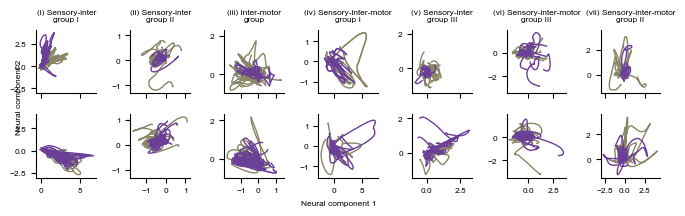

In [37]:
save_file = False
plot_neuron_component_trajectories_grid(projected_tl_neuron, learning_wormdict=learnNum, comps=[0,1], save=save_file)

## Supplementary Data 2

In [38]:
def split_naive_trained_DTW(X, n_naive):
    return X[..., :n_naive], X[..., n_naive:]

def to_TWd_from_DTW(X, d=2):
    # X: (D,T,W) → (T,W,d) using first d neural components
    X = np.asarray(X)
    assert X.ndim == 3 and X.shape[0] >= d
    return np.transpose(X[:d, ...], (1, 2, 0))  # (T,W,d)

In [39]:
alpha=0.05
rows = []
d=2
for genotype, prom_dict in projected_tl_neuron.items():
    for promoter, stim_dict in prom_dict.items():
        for stimulus, X_DTW in stim_dict.items():
            X = np.asarray(X_DTW)  # (D,T,W)
            if X.ndim != 3 or X.shape[0] < d:
                continue
            T = X.shape[1]
            n_naive = int(learnNum[genotype][promoter][stimulus]['naive'])
            Xn_DTW, Xt_DTW = split_naive_trained_DTW(X, n_naive)
            # to (T,W,d)
            Xn_TWd = to_TWd_from_DTW(Xn_DTW, d=d)
            Xt_TWd = to_TWd_from_DTW(Xt_DTW, d=d)
            
            print(genotype, promoter_names[promoter], stimulus)
            ang_cov, p_cov, null_cov = perm_test_global_covtilt(X, n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
            obs_cont, p_cont, null_cont = perm_test_global_contraction_area_ratio(X, n_naive, tstart=150, nperm=10000, seed=cedne.RANDOM_SEED)
            rows.append(dict(
                genotype=genotype, promoter=promoter_names[promoter], stimulus=stimulus, d=d,
                T=T, W_naive=Xn_TWd.shape[1], W_trained=Xt_TWd.shape[1],
                rotation_deg=ang_cov, p_rotation=p_cov,
                contraction_ratio = obs_cont, p_contraction=p_cont
                # contraction_ratio=contr['ratio'], p_contraction=contr['p']
            ))

df = pd.DataFrame(rows)

# FDR across all tests (separately for rotation and contraction)
df['q_rotation']    = multipletests(df['p_rotation'].values,   method='fdr_bh')[1]
df['q_contraction'] = multipletests(df['p_contraction'].values,method='fdr_bh')[1]

# flags
df['sig_rotation']    = df['q_rotation']    < alpha
df['sig_contraction'] = df['q_contraction'] < alpha

# nice ordering
df = df.sort_values(['genotype', 'promoter','stimulus','genotype']).reset_index(drop=True)    

N2 sensory-inter group I OP-PA-OP
N2 sensory-inter group I Buffer-PA-Buffer
N2 sensory-inter group II OP-PA-OP
N2 sensory-inter group II Buffer-PA-Buffer
N2 inter-motor group OP-PA-OP
N2 inter-motor group Buffer-PA-Buffer
N2 sensory-inter-motor group I OP-PA-OP
N2 sensory-inter-motor group I Buffer-PA-Buffer
N2 sensory-inter group III OP-PA-OP
N2 sensory-inter group III Buffer-PA-Buffer
N2 sensory-inter-motor group III OP-PA-OP
N2 sensory-inter-motor group III Buffer-PA-Buffer
N2 sensory-inter-motor group II OP-PA-OP
N2 sensory-inter-motor group II Buffer-PA-Buffer


In [ ]:
df_filt = df[['promoter','stimulus',
'rotation_deg','q_rotation',
'contraction_ratio','q_contraction']].head(20)
df_filt = df_filt.rename(columns={
    "rotation_deg": "rotation",
    "contraction_ratio": "contraction"
})
df_filt.columns = [c.replace('_', r'\_') for c in df_filt.columns]